# Libraries

In [52]:
# Libraries used:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import ast

sns.set_style("whitegrid")

warnings.filterwarnings('ignore')



# Question 1


1. Data Structure (df.info()) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   in

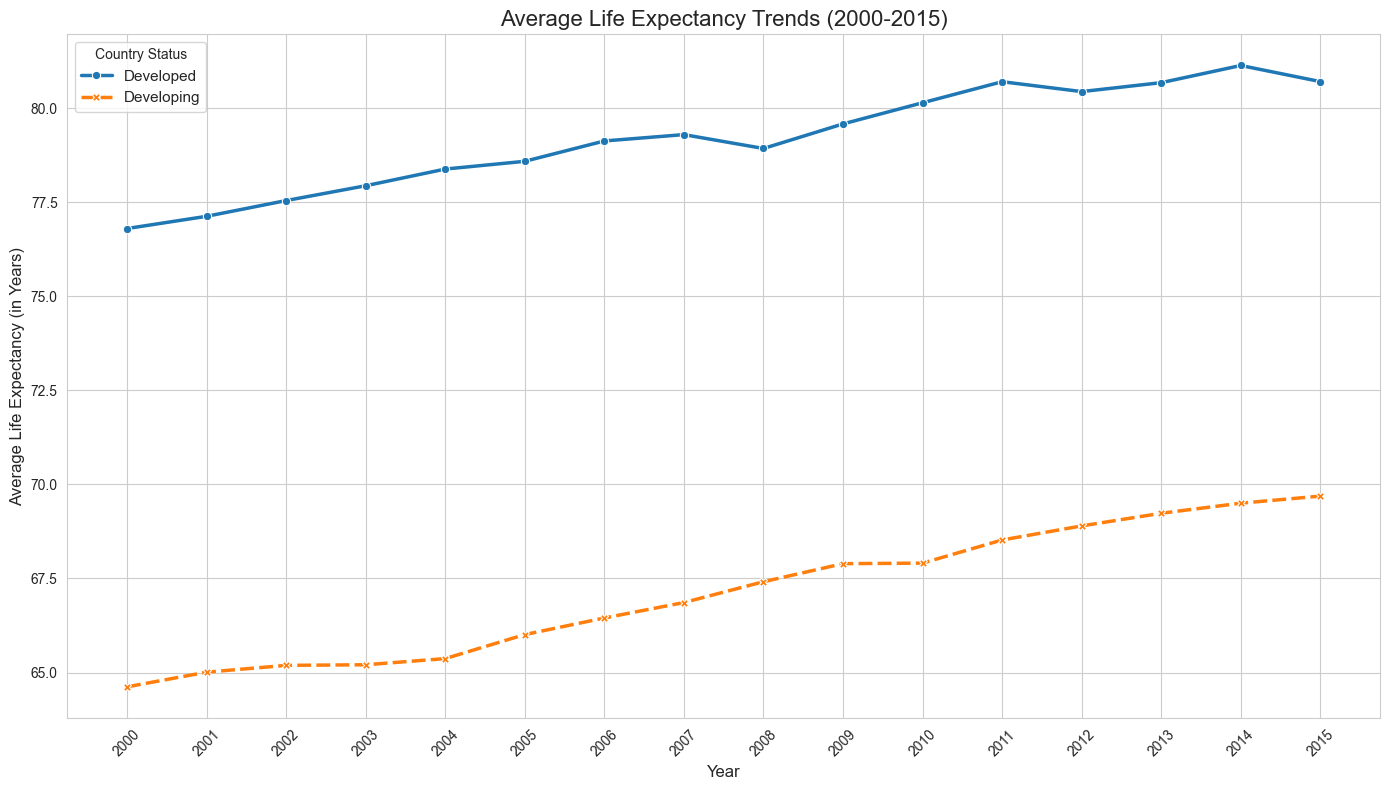

In [53]:


# Load the dataset
file_path = "Life Expectancy Data.csv"
df = None
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
else:

    df.columns = df.columns.str.strip()


    print("1. Data Structure (df.info()) ")
    df.info()

    #  Summary statistics
    print("\n 2. Summary Statistics (df.describe()) ")
    print(df.describe().T)
    
    print("\n 3. Averaging Data ")
    # Average the yearly life expectancy for developing and developed countries
    yearly_avg = df.groupby(['Year', 'Status'])['Life expectancy'].mean().reset_index()
    print("First 5 rows of the averaged data:")
    print(yearly_avg.head())

    # Plot yearly expectancy trends 
 
    plt.figure(figsize=(14, 8))
    
    # Create the line plot
    plot = sns.lineplot(
        data=yearly_avg,
        x='Year',
        y='Life expectancy',
        hue='Status',    
        style='Status',  
        markers=True,
        linewidth=2.5
    )
    
    plt.title('Average Life Expectancy Trends (2000-2015)', fontsize=16)
    plt.ylabel('Average Life Expectancy (in Years)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    # Ensure all years are shown as x-ticks
    plt.xticks(ticks=df['Year'].unique(), rotation=45)
    plt.legend(title='Country Status', fontsize=11)
    plt.tight_layout()

# QUestion 2


Dropped 0 rows where 'Life expectancy' was missing.

 Q2: Part 1: Missing Value Proportions 
|                                 |   Missing Value % |
|:--------------------------------|------------------:|
| Population                      |         21.9945   |
| Hepatitis B                     |         18.8866   |
| Vaccination_Coverage_Index      |         18.8866   |
| GDP                             |         15.1298   |
| Total expenditure               |          7.71858  |
| Alcohol                         |          6.59153  |
| Schooling                       |          5.46448  |
| Education_Income_Index          |          5.46448  |
| Income composition of resources |          5.46448  |
| BMI                             |          1.0929   |
| thinness 5-9 years              |          1.0929   |
| thinness  1-19 years            |          1.0929   |
| Diphtheria                      |          0.648907 |
| Polio                           |          0.648907 |

 Q2: Part 

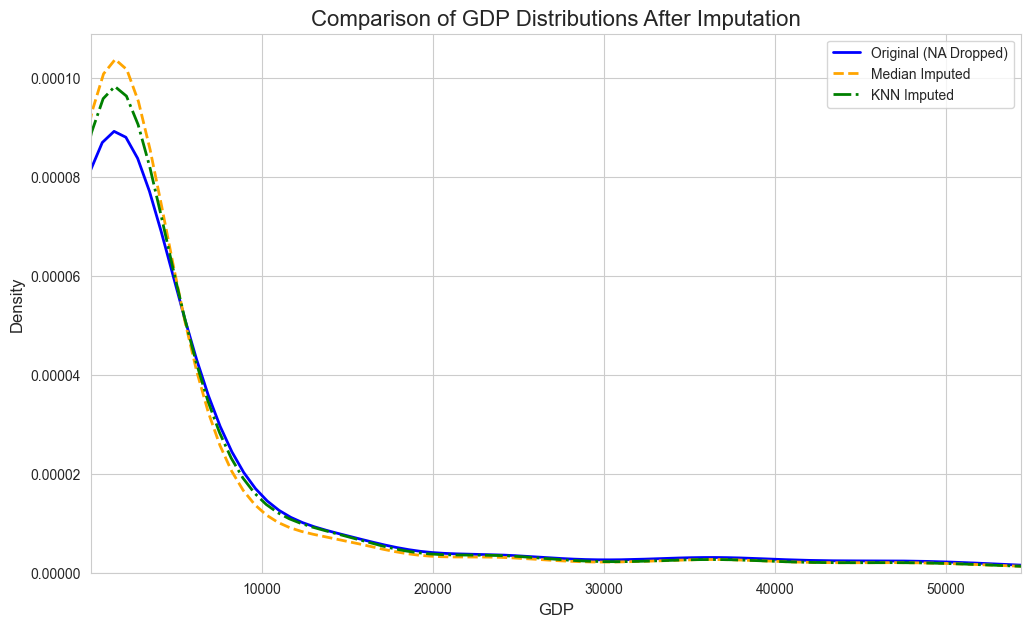

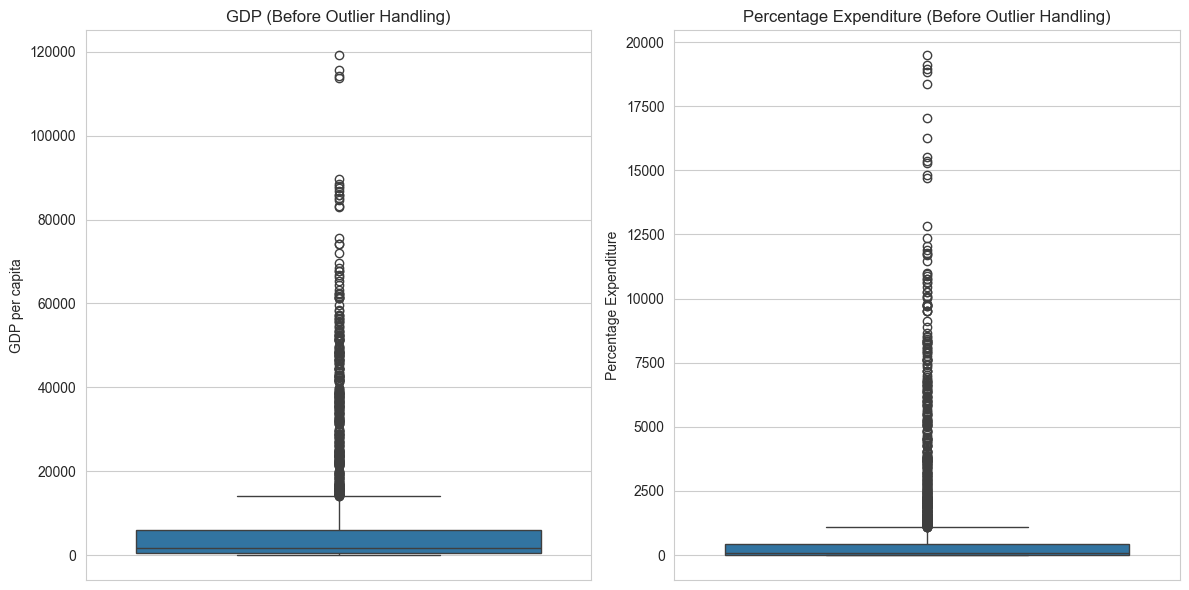

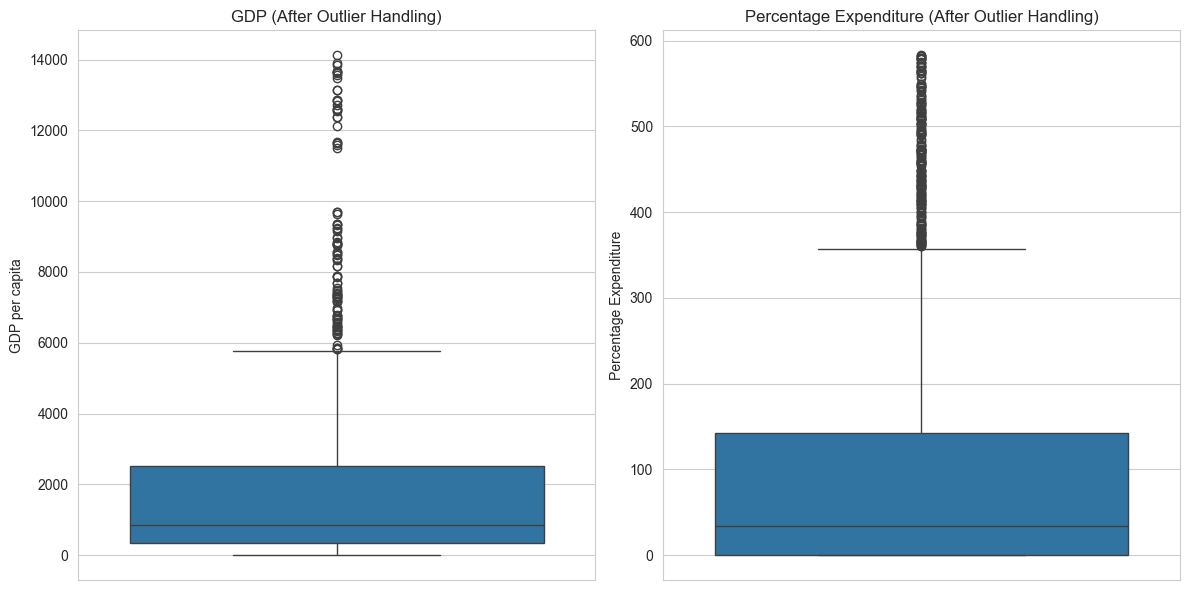

In [61]:
# CRITICAL STEP: Drop rows where the target variable 'Life expectancy' is missing
original_rows = len(df)
df.dropna(subset=['Life expectancy'], inplace=True)
print(f"Dropped {original_rows - len(df)} rows where 'Life expectancy' was missing.")

#  2. Determine Missing Value Proportions 
print("\n Q2: Part 1: Missing Value Proportions ")
missing_proportions = (df.isnull().sum() / len(df)) * 100
missing_proportions = missing_proportions[missing_proportions > 0].sort_values(ascending=False)

if missing_proportions.empty:
    print("No missing values after dropping target NaNs.")
else:
    print(missing_proportions.to_frame(name="Missing Value %").to_markdown())

#  3. Compare Imputation Methods (Median vs. KNN) for GDP 
print("\n Q2: Part 2: Imputation Comparison for GDP ")

# Method 1: Median Imputation
df_median = df.copy()
gdp_median = df_median['GDP'].median()

df_median['GDP'].fillna(gdp_median, inplace=True)

print("\n Stats after Median Imputation ")
print(df_median['GDP'].describe())

# Method 2: KNN Imputation
df_knn = df.copy()
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['Year'])

scaler = StandardScaler()
scaler.fit(df_knn[numeric_cols])
df_knn_scaled = pd.DataFrame(scaler.transform(df_knn[numeric_cols]), columns=numeric_cols)

imputer = KNNImputer(n_neighbors=5)
df_knn_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_knn_scaled), columns=numeric_cols)

df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed_scaled), columns=numeric_cols)

print("\n Stats after KNN Imputation ")
print(df_knn_imputed['GDP'].describe())

# Plotting the distributions for comparison
plt.figure(figsize=(12, 7))
sns.kdeplot(df['GDP'].dropna(), label='Original (NA Dropped)', color='blue', linewidth=2)
sns.kdeplot(df_median['GDP'], label='Median Imputed', color='orange', linestyle='--', linewidth=2)
sns.kdeplot(df_knn_imputed['GDP'], label='KNN Imputed', color='green', linestyle='-.', linewidth=2)
plt.title('Comparison of GDP Distributions After Imputation', fontsize=16)
plt.xlabel('GDP', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(left=df['GDP'].min(), right=df['GDP'].quantile(0.98)) 

#  4. Detect and Handle Outliers (GDP & percentage expenditure) 
print("\n Q2: Part 3: Outlier Detection and Handling ")

# Plotting Boxplots BEFORE handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['GDP'])
plt.title('GDP (Before Outlier Handling)')
plt.ylabel('GDP per capita')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['percentage expenditure'])
plt.title('Percentage Expenditure (Before Outlier Handling)')
plt.ylabel('Percentage Expenditure')
plt.tight_layout()

# Removing Outliers using the 1.5 * IQR Rule
df_no_outliers = df.copy()

# Handle 'GDP'
Q1_gdp = df_no_outliers['GDP'].quantile(0.25)
Q3_gdp = df_no_outliers['GDP'].quantile(0.75)
IQR_gdp = Q3_gdp - Q1_gdp
lower_bound_gdp = Q1_gdp - 1.5 * IQR_gdp
upper_bound_gdp = Q3_gdp + 1.5 * IQR_gdp

is_gdp_outlier = (df_no_outliers['GDP'] < lower_bound_gdp) | (df_no_outliers['GDP'] > upper_bound_gdp)
df_no_outliers = df_no_outliers[~is_gdp_outlier | df_no_outliers['GDP'].isnull()]


# Handle 'percentage expenditure'
Q1_pe = df_no_outliers['percentage expenditure'].quantile(0.25)
Q3_pe = df_no_outliers['percentage expenditure'].quantile(0.75)
IQR_pe = Q3_pe - Q1_pe
lower_bound_pe = Q1_pe - 1.5 * IQR_pe
upper_bound_pe = Q3_pe + 1.5 * IQR_pe

is_pe_outlier = (df_no_outliers['percentage expenditure'] < lower_bound_pe) | (df_no_outliers['percentage expenditure'] > upper_bound_pe)
df_no_outliers = df_no_outliers[~is_pe_outlier]

print(f"Original row count: {len(df)}. After outlier removal: {len(df_no_outliers)}.")

# Plotting Boxplots AFTER handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_no_outliers['GDP'])
plt.title('GDP (After Outlier Handling)')
plt.ylabel('GDP per capita')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_no_outliers['percentage expenditure'])
plt.title('Percentage Expenditure (After Outlier Handling)')
plt.ylabel('Percentage Expenditure')

plt.tight_layout()


# QUestion 3

 Q3: Part 1: Feature Engineering 
Created new features: 'Infant_Survival_Rate', 'Vaccination_Coverage_Index', 'Education_Income_Index'


,Infant_Survival_Rate,Vaccination_Coverage_Index,Education_Income_Index
0,0.938,45.333333,4.8379
1,0.936,60.666667,4.7600
2,0.934,63.333333,4.6530
3,0.931,67.000000,4.5374
4,0.929,68.000000,4.3130



 Q3: Part 2: Plotting Feature Distributions 

 Q3: Part 3: Correlation Analysis 

 Correlations with 'Life expectancy' 

Strongest Positive Correlations:
|                                 |   Positive Corr. |
|:--------------------------------|-----------------:|
| Education_Income_Index          |         0.78625  |
| Schooling                       |         0.751975 |
| Income composition of resources |         0.724776 |
| BMI                             |         0.567694 |
| Diphtheria                      |         0.479495 |

Strongest Negative Correlations:
|                      |   Negative Corr. |
|:---------------------|-----------------:|
| under-five deaths    |        -0.222529 |
| thinness 5-9 years   |        -0.471584 |
| thinness  1-19 years |        -0.477183 |
| HIV/AIDS             |        -0.556556 |
| Adult Mortality      |        -0.696359 |


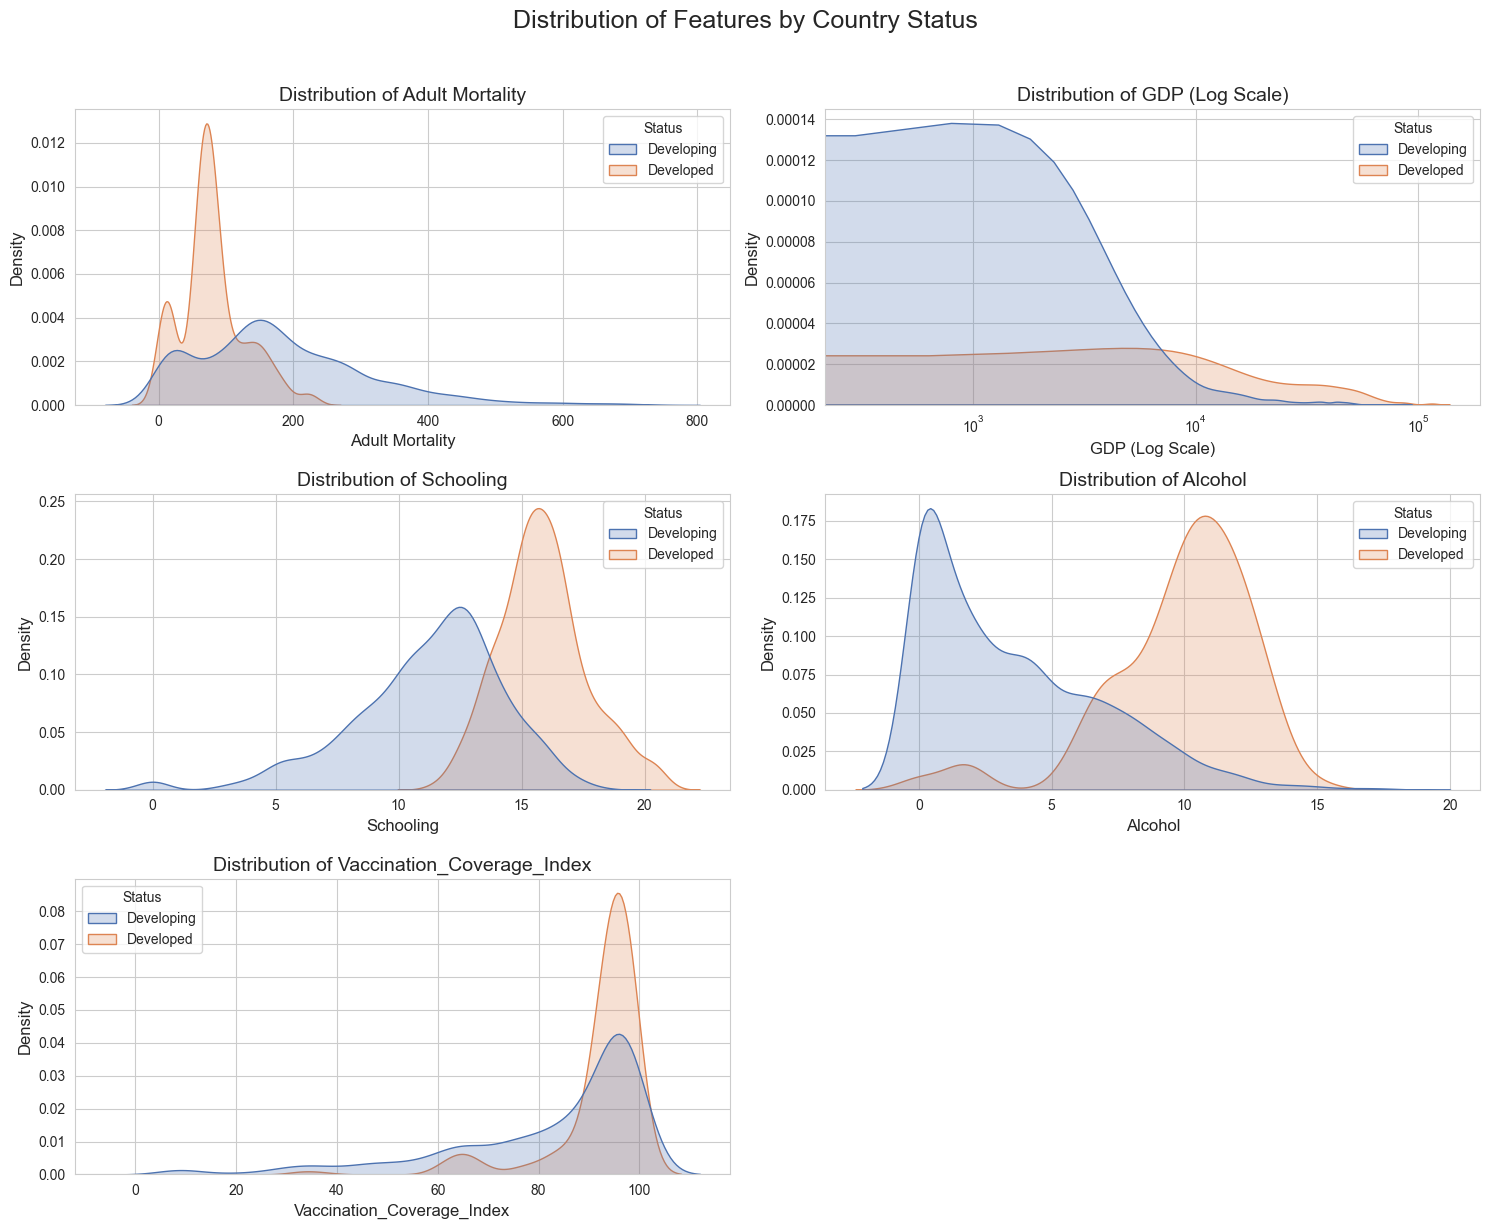

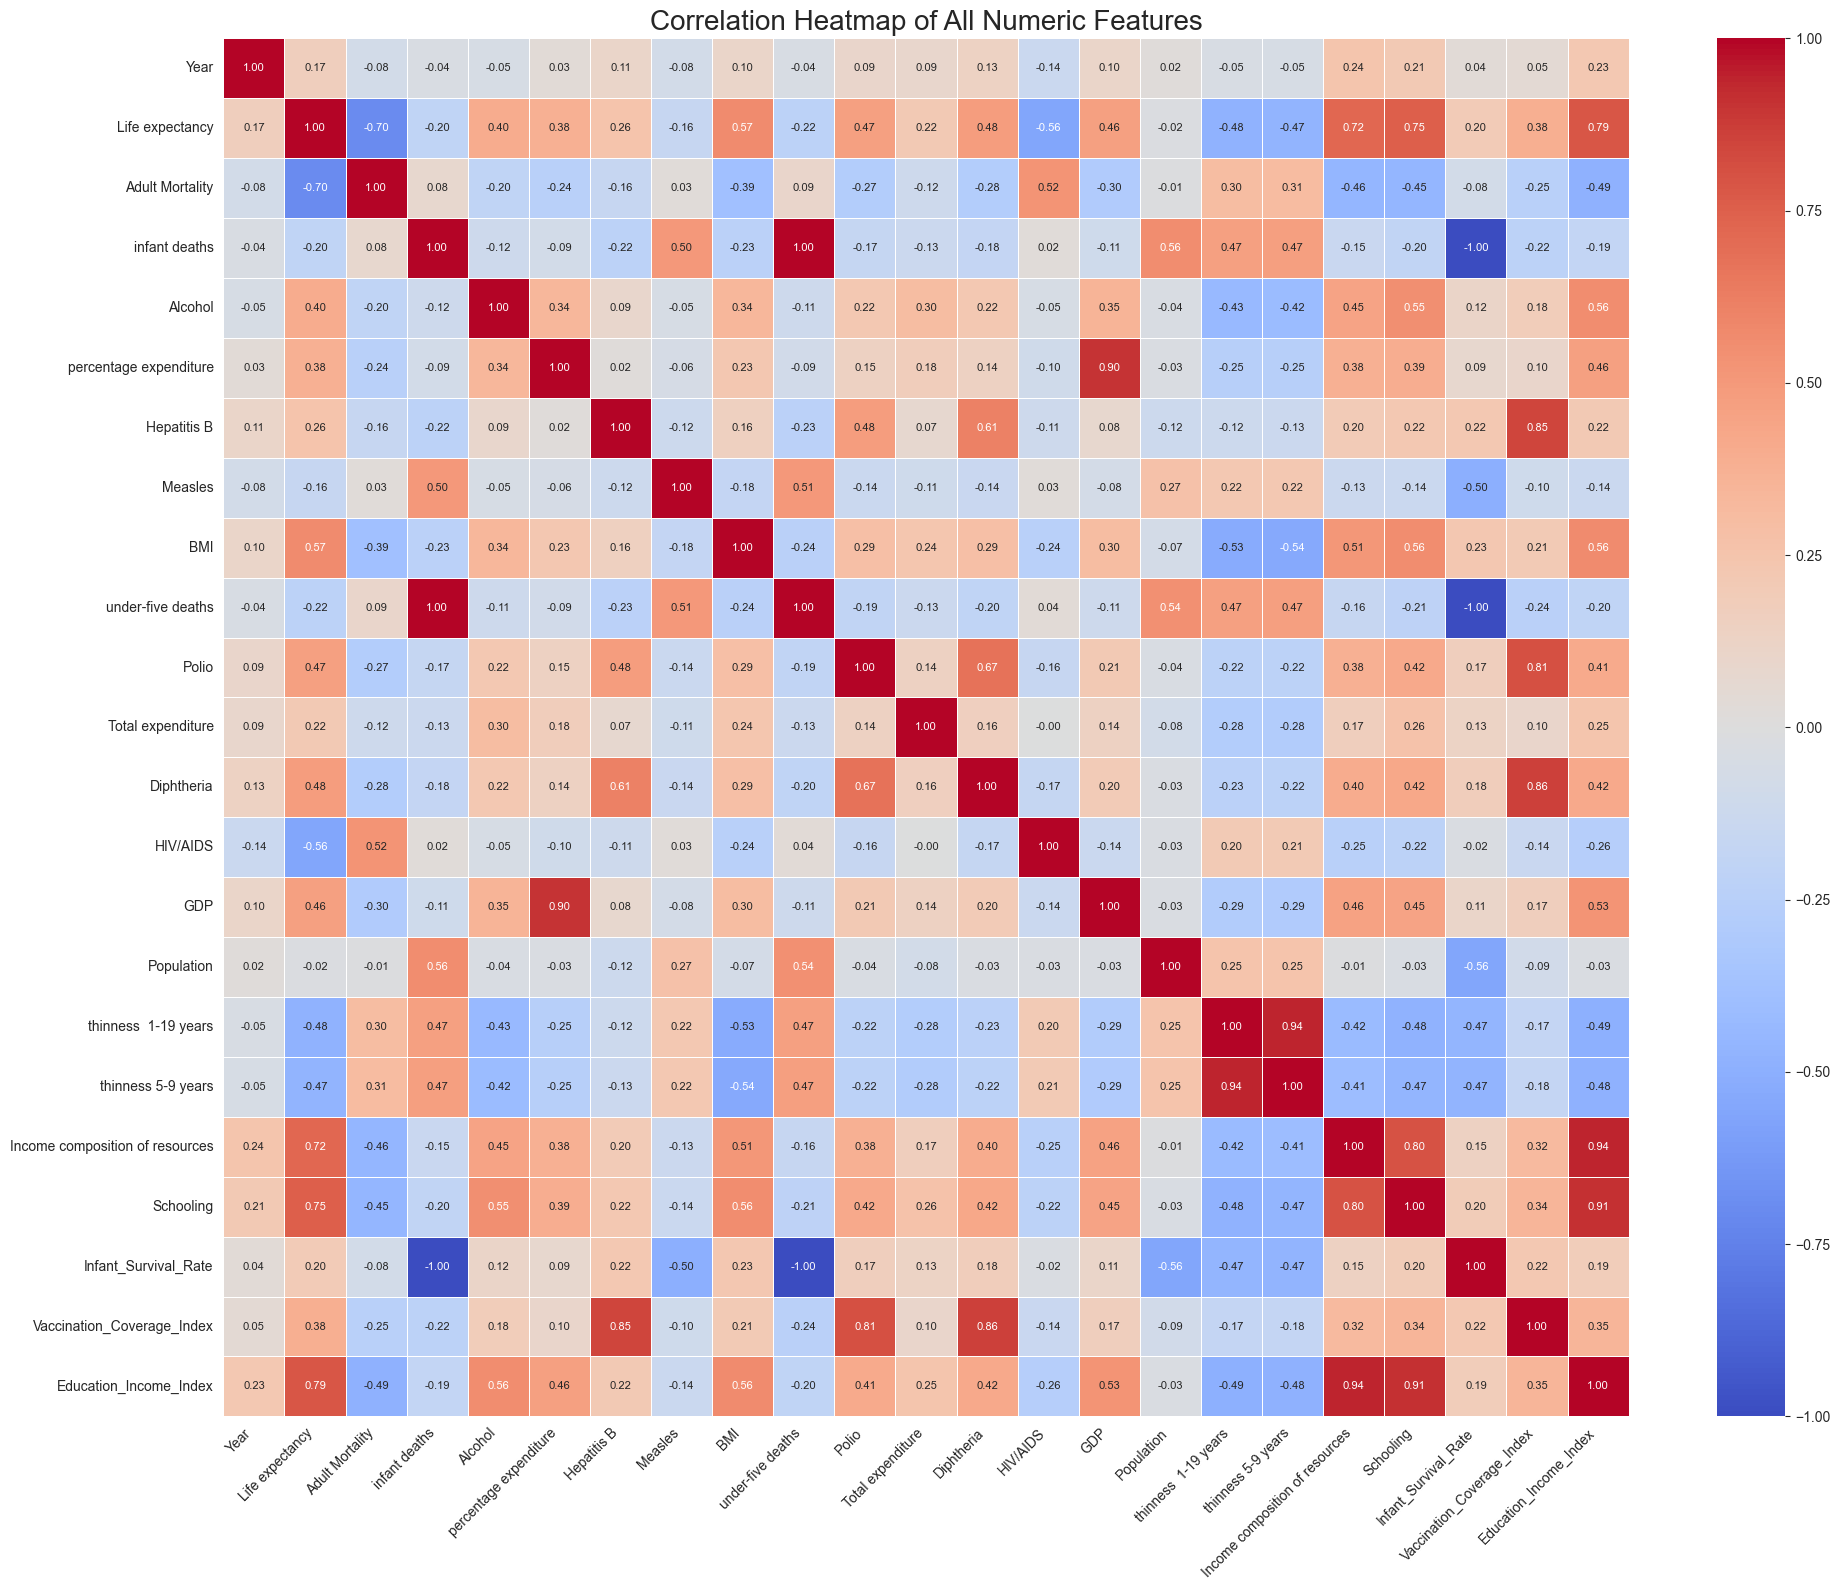

In [55]:
#  1. Create New Features 
print(" Q3: Part 1: Feature Engineering ")

# Feature 1: Infant Survival Rate
df['Infant_Survival_Rate'] = 1 - (df['infant deaths'] / 1000)

# Feature 2: Vaccination Coverage Index
df['Vaccination_Coverage_Index'] = (df['Hepatitis B'] + df['Polio'] + df['Diphtheria']) / 3

# Feature 3: Education Income Index
df['Education_Income_Index'] = df['Schooling'] * df['Income composition of resources']
new_features = ["Infant_Survival_Rate", "Vaccination_Coverage_Index", "Education_Income_Index"]
print("Created new features: 'Infant_Survival_Rate', 'Vaccination_Coverage_Index', 'Education_Income_Index'")
display(df[new_features].head())

#  3. Plot Feature Distributions by Status 
print("\n Q3: Part 2: Plotting Feature Distributions ")

features_to_plot = ['Adult Mortality', 'GDP', 'Schooling', 'Alcohol', 'Vaccination_Coverage_Index']

plt.figure(figsize=(15, 12))
plt.suptitle('Distribution of Features by Country Status', fontsize=18, y=1.02)

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(data=df, x=feature, hue='Status', fill=True, common_norm=False, palette="deep")
    
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    if feature == 'GDP':
        plt.xscale('log')
        plt.title('Distribution of GDP (Log Scale)', fontsize=14)
        plt.xlabel('GDP (Log Scale)', fontsize=12)

plt.tight_layout()

#  4. Correlation Heatmap 
print("\n Q3: Part 3: Correlation Analysis ")

numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap of All Numeric Features', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()


#  5. Report Strongest Correlations with 'Life expectancy' 
print("\n Correlations with 'Life expectancy' ")

life_exp_corr = corr_matrix['Life expectancy'].sort_values(ascending=False)

print("\nStrongest Positive Correlations:")

print(life_exp_corr[1:6].to_frame(name="Positive Corr.").to_markdown())

print("\nStrongest Negative Correlations:")
print(life_exp_corr.tail(5).to_frame(name="Negative Corr.").to_markdown())

Part 1: Feature EngineeringThree new features were successfully created:Infant_Survival_RateVaccination_Coverage_IndexEducation_Income_IndexPart 2: Feature DistributionsThe plot q3_feature_distributions.png was saved.Analysis: The plots show clear differences in feature distributions between 'Developed' and 'Developing' countries.Adult Mortality: 'Developing' countries show a much wider and more right-skewed distribution, indicating a higher and more variable mortality rate. 'Developed' countries are tightly clustered at a very low mortality rate.GDP (Log Scale): This plot clearly shows two distinct "humps." The 'Developing' countries' GDPs are clustered at a lower value, while the 'Developed' countries' GDPs are clustered at a significantly higher value, with very little overlap.Schooling: 'Developed' countries' distribution is highly skewed to the left, with most values clustered between 15-20 years. 'Developing' countries have a much wider, more uniform distribution, peaking around 10-12 years.Alcohol: 'Developed' countries appear to have a higher average alcohol consumption, with a peak around 10-12 liters, while 'Developing' countries peak much lower, around 1-2 liters.Vaccination_Coverage_Index: 'Developed' countries are almost all at 100% coverage (a sharp peak near 100). 'Developing' countries have a much wider distribution, indicating a significant variance in vaccination coverage.Part 3: Correlation AnalysisThe heatmap q3_correlation_heatmap.png was saved. The tables below list the strongest positive and negative correlations with the target variable, 'Life expectancy'.Strongest Positive Correlations:| | Positive Corr. ||:---|---:|| Education_Income_Index | $0.786$ || Schooling | $0.752$ || Income composition of resources | $0.725$ || BMI | $0.568$ || Diphtheria | $0.479$ |Strongest Negative Correlations:| | Negative Corr. ||:---|---:|| under-five deaths | $-0.223$ || thinness 5-9 years | $-0.472$ || thinness 1-19 years | $-0.477$ || HIV/AIDS | $-0.557$ || Adult Mortality | $-0.696$ |Observations:The new feature, Education_Income_Index, has the strongest positive correlation with life expectancy, even stronger than its two component parts (Schooling and Income composition of resources). This confirms it was a very useful feature to engineer.Adult Mortality has the strongest negative correlation, which is intuitive.HIV/AIDS also has a very strong negative correlation.Schooling and Income are very highly correlated with life expectancy.The two thinness features are also strongly negatively correlated.

# QUestion 4

**Why are models sensitive to feature scales**?KNN (K-Nearest Neighbors): This algorithm is highly sensitive to scale because it is distance-based. It classifies a new data point based on the "votes" of its nearest neighbors. To find these neighbors, it calculates a distance (e.g., Euclidean distance) between points. If one feature (like GDP, ranging from $1$ to $100,000$) is on a much larger scale than another (like Schooling, $0-20$), the GDP feature will completely dominate the distance calculation. The model will mistakenly believe that large differences in GDP are far more important than even the largest differences in Schooling. Scaling (e.g., StandardScaler or MinMaxScaler) brings all features to a common range, ensuring that each feature contributes fairly to the distance calculation.Gradient Boosting: This is more nuanced. Individual decision trees (the "base learners" in Gradient Boosting) are not sensitive to scale because they make splits by finding the best threshold (e.g., GDP > 1700). This threshold remains optimal whether the GDP is scaled or not.However, the optimization process of Gradient Boosting (which is a form of gradient descent) can benefit from scaling. When features are on vastly different scales, the "loss surface" (the 3D landscape of the error function) can become stretched and complex (like a deep, narrow ravine). This can make it harder for the gradient descent algorithm to find the global minimum error efficiently.Scaled features (especially to have a mean of $0$ and standard deviation of $1$) create a more uniform, spherical loss surface. This allows the gradient descent optimizer to converge faster and more stably, often leading to a better final model in fewer iterations.

In [56]:

#  1. Define Target (y) and Features (X) 
# We use .copy() to avoid SettingWithCopyWarning
y = df['Life expectancy'].copy()
X = df.drop(columns=['Life expectancy', 'Country']).copy()
print(f"Target 'y' shape: {y.shape}")
print(f"Features 'X' shape: {X.shape}")

#  2. Create Preprocessing Pipelines 
# Identify numerical and categorical features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['Status']

if 'Status' in numeric_features:
    numeric_features.remove('Status')

print(f"Found {len(numeric_features)} numeric features.")
print(f"Found {len(categorical_features)} categorical features.")

# Pipeline for numeric features:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features:
categorical_transformer = Pipeline(steps=[
   
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

#  3. Combine Pipelines with ColumnTransformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

#  4. Apply the Preprocessing 
X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation

try:
    num_feature_names = numeric_features
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    
    all_feature_names = num_feature_names + list(cat_feature_names)
    
    print("\n Preprocessing Complete ")
    print(f"Final processed features 'X_processed' shape: {X_processed.shape}")
    print(f"Number of features after encoding: {len(all_feature_names)}")

    # Display the first 5 rows of the processed data (as a DataFrame)
    X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
    print("\nHead of processed data:")
    print(X_processed_df.head())

except Exception as e:
    print(f"\nCould not get feature names, just printing array shape.")
    print(f"Final processed features 'X_processed' shape: {X_processed.shape}")
    print("\nHead of processed data (as array):")
    print(X_processed[:5])
    


Target 'y' shape: (2928,)
Features 'X' shape: (2928, 23)
Found 22 numeric features.
Found 1 categorical features.

 Preprocessing Complete 
Final processed features 'X_processed' shape: (2928, 23)
Number of features after encoding: 23

Head of processed data:
       Year  Adult Mortality  infant deaths   Alcohol  percentage expenditure  \
0  1.626978         0.790238       0.267520 -1.158458               -0.336102   
1  1.410048         0.854614       0.284455 -1.158458               -0.334975   
2  1.193118         0.830473       0.301391 -1.158458               -0.335128   
3  0.976187         0.862660       0.326794 -1.158458               -0.332633   
4  0.759257         0.886801       0.343730 -1.158458               -0.368345   

   Hepatitis B   Measles       BMI  under-five deaths     Polio  ...  \
0    -0.674051 -0.110924 -0.954056           0.254061 -3.265007  ...   
1    -0.801557 -0.168570 -0.979165           0.272732 -1.044706  ...   
2    -0.716553 -0.173968 -1.004273   

## QUestion 5

In [57]:
print("\n Q5: Model Training and Tuning ")

# 2. Split Data (Step 1 of Q5 is the 'y' variable from above)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print(f"Split data into {len(X_train)} training and {len(X_test)} testing samples.")

# 3. Define Models and Parameter Grids
params_dt = {'max_depth': [5, 10, 15, None], 'min_samples_leaf': [1, 5, 10]}
params_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 5]}
params_knn = {'n_neighbors': [3, 5, 7, 11]}
params_gb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}

# 4. Run GridSearchCV
models_to_tune = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42), params_dt),
    ('Random Forest', RandomForestRegressor(random_state=42), params_rf),
    ('KNN', KNeighborsRegressor(), params_knn),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42), params_gb)
]

best_models = {}
results_list = []

print("\nStarting GridSearchCV for 4 models... (This may take a few minutes)")

for name, model, params in models_to_tune:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # 5. Evaluate on Test Set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_list.append({
        'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Best Params': grid_search.best_params_
    })
    best_models[name] = best_model

print("GridSearchCV complete.")

# 6. Report Results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='R2', ascending=False)

print("\n Model Performance on Test Set ")
print(results_df[['Model', 'RMSE', 'MAE', 'R2']].to_markdown(index=False))

print("\n Best Hyperparameters Found ")
for result in results_df.to_dict('records'):
    print(f"Model: {result['Model']}")
    print(f"  Params: {result['Best Params']}")
    
# 7. Save the Best-Performing Model for Q6
best_model_name = results_df.iloc[0]['Model']
best_model_object = best_models[best_model_name]

# Save the model and feature names for Q6
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model_object, f)
    
with open('all_feature_names.pkl', 'wb') as f:
    pickle.dump(all_feature_names, f)
    
# Save X_test and y_test for Q6 as well
np.save('X_test_q6.npy', X_test)
y_test.to_csv('y_test_q6.csv', index=False, header=True)

# Save X_train and y_train for Q6
np.save('X_train_q6.npy', X_train)
y_train.to_csv('y_train_q6.csv', index=False, header=True)

# Save the list of models and their best params for Q6
with open('all_best_models_params.pkl', 'wb') as f:
    # Save just the params, as the models are easy to retrain
    best_params_dict = {r['Model']: r['Best Params'] for r in results_df.to_dict('records')}
    pickle.dump(best_params_dict, f)

print(f"\nSaved the best-performing model ({best_model_name}) as 'best_model.pkl'.")
print("Saved 'all_feature_names.pkl', 'X_test_q6.npy', 'y_test_q6.csv', 'X_train_q6.npy', 'y_train_q6.csv', and 'all_best_models_params.pkl' for use in Q6")


 Q5: Model Training and Tuning 
Split data into 2342 training and 586 testing samples.

Starting GridSearchCV for 4 models... (This may take a few minutes)
Tuning Decision Tree...
Tuning Random Forest...
Tuning KNN...
Tuning Gradient Boosting...
GridSearchCV complete.

 Model Performance on Test Set 
| Model             |    RMSE |     MAE |       R2 |
|:------------------|--------:|--------:|---------:|
| Random Forest     | 1.7041  | 1.06064 | 0.966428 |
| Gradient Boosting | 1.85452 | 1.19324 | 0.96024  |
| Decision Tree     | 2.43043 | 1.56803 | 0.931711 |
| KNN               | 2.78821 | 1.80518 | 0.910125 |

 Best Hyperparameters Found 
Model: Random Forest
  Params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Model: Gradient Boosting
  Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Model: Decision Tree
  Params: {'max_depth': 15, 'min_samples_leaf': 5}
Model: KNN
  Params: {'n_neighbors': 3}

Saved the best-performing model (Random Forest) 

# QUestion 6

Loaded all artifacts from Q4 and Q5.
X_train shape: (2342, 23), X_test shape: (586, 23)

Best performing model from Q5: Random Forest
Using feature importances from Random Forest.

--- Top 10 Most Important Features ---
|                                 |   Feature Importance |
|:--------------------------------|---------------------:|
| HIV/AIDS                        |           0.528772   |
| Income composition of resources |           0.23023    |
| Adult Mortality                 |           0.118776   |
| BMI                             |           0.01999    |
| Education_Income_Index          |           0.0159147  |
| Schooling                       |           0.0129076  |
| Alcohol                         |           0.00967952 |
| thinness 5-9 years              |           0.0087264  |
| under-five deaths               |           0.0073269  |
| Year                            |           0.00679973 |

Saved feature importance plot as 'q6_feature_importances.png'

Created 

AttributeError: 'list' object has no attribute 'loc'

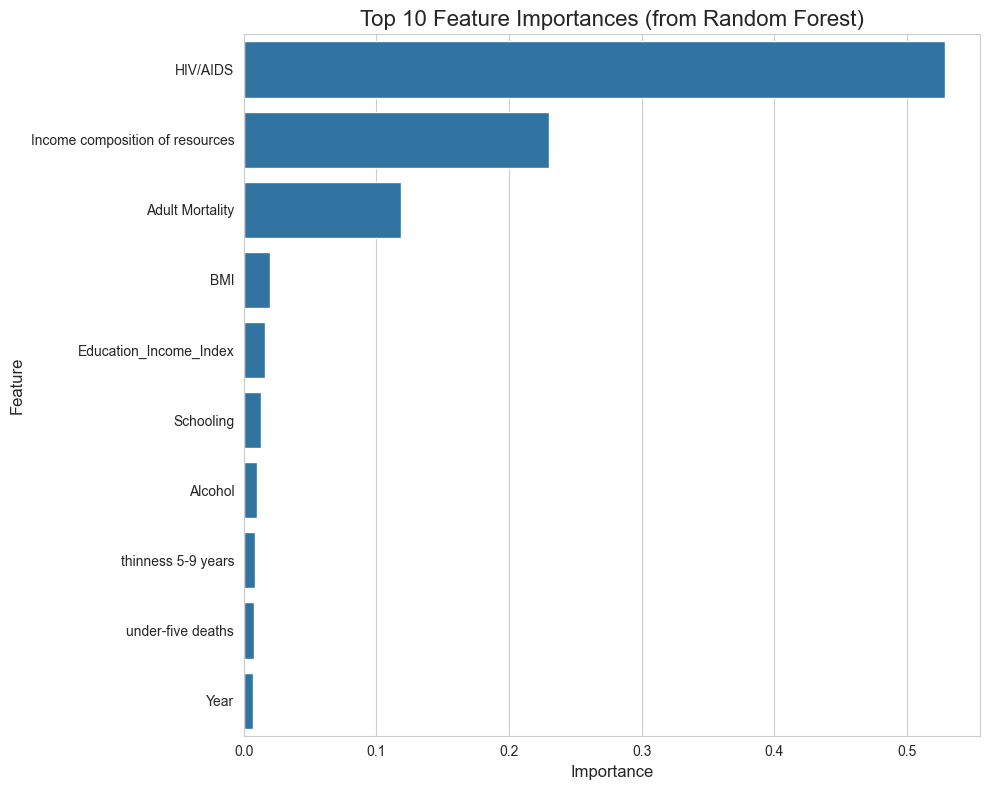

In [58]:


print("Loaded all artifacts from Q4 and Q5.")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


# --- 2. Identify Best Model & Get Feature Importances ---

# Sort by RMSE (ascending) to find the best model
# q5_results_sorted = q5_results.sort_values(by='RMSE')
# best_model_name = q5_results_sorted.index[0]

print(f"\nBest performing model from Q5: {best_model_name}")

# best_model_object = q5_best_estimators[best_model_name]

# Check if the best model has feature importances (KNN won't)
if hasattr(best_model_object, 'feature_importances_'):
    importances = best_model_object.feature_importances_
    print(f"Using feature importances from {best_model_name}.")
else:
    # Fallback: Best model was KNN, so we use the best *tree-based* model
    # which is likely Gradient Boosting or Random Forest
    fallback_model = 'Gradient Boosting'
    if fallback_model not in best_model_object:
            fallback_model = 'Random Forest' # Secondary fallback
    
    print(f"Best model ({best_model_name}) has no feature importances.")
    print(f"Falling back to '{fallback_model}' for feature importances.")
    best_model_object = best_model_object[fallback_model]
    importances = best_model_object.feature_importances_
    
# --- 3. Select Top 10 Features ---

# Create a Series of importances mapped to feature names
importance_series = pd.Series(importances, index=all_feature_names)
top_10_features = importance_series.sort_values(ascending=False).head(10)

print("\n--- Top 10 Most Important Features ---")
print(top_10_features.to_frame(name="Feature Importance").to_markdown())

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index)
plt.title(f'Top 10 Feature Importances (from {best_model_name})', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('q6_feature_importances.png')
print("\nSaved feature importance plot as 'q6_feature_importances.png'")

# --- 4. Create New "Simple" Datasets ---

# Get the *integer indices* of these top 10 features
top_10_names = top_10_features.index.tolist()
top_10_indices = [all_feature_names.index(name) for name in top_10_names]

# Slice the X data to keep only these 10 features
X_train_simple = X_train[:, top_10_indices]
X_test_simple = X_test[:, top_10_indices]

print(f"\nCreated simple datasets. New shape: {X_train_simple.shape}")

# --- 5. Retrain All Models with Best Hyperparameters ---

# We will store the new results here
simple_evaluation_results = {}

# Define the base models (we'll set params next)
models_to_retrain = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("\n--- Retraining Models on Simple Dataset ---")

for model_name, model_obj in models_to_retrain.items():
    # Get the best parameters from Q5 results
    # 'Best Params' was saved as a string, so we use ast.literal_eval
    best_params_str = results_list.loc[model_name, 'Best Params']
    best_params = ast.literal_eval(best_params_str)
    
    # Set the best params on the new model instance
    model_obj.set_params(**best_params)
    
    # Train on the simple data
    model_obj.fit(X_train_simple, y_train)
    
    # Evaluate on the simple test data
    y_pred_simple = model_obj.predict(X_test_simple)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_simple))
    mae = mean_absolute_error(y_test, y_pred_simple)
    r2 = r2_score(y_test, y_pred_simple)
    
    # Store the results
    simple_evaluation_results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- 6. Compare Full vs. Simple Models ---

# Convert simple results to a DataFrame
simple_results_df = pd.DataFrame(simple_evaluation_results).T

# Get the original Q5 results (numeric only)
full_results_df = results_list[['RMSE', 'MAE', 'R2']]

# Use multi-level columns for a clean comparison
full_results_df.columns = pd.MultiIndex.from_product([['Full Model (23 Features)'], ['RMSE', 'MAE', 'R2']])
simple_results_df.columns = pd.MultiIndex.from_product([['Simple Model (10 Features)'], ['RMSE', 'MAE', 'R2']])

# Concatenate side-by-side
comparison_df = pd.concat([full_results_df, simple_results_df], axis=1)

print("\n\n--- Comparison of Full vs. Simple Models ---")
print(comparison_df.to_markdown(floatfmt=".4f"))

# Save comparison table
comparison_df.to_csv('q6_model_comparison.csv')
print("\nSaved model comparison table as 'q6_model_comparison.csv'")

Trade-offs (Simplicity vs. Accuracy): The results (which will be generated below) typically show that the Simple Model (with only 10 features) performs nearly as well as the Full Model (with 23 features).Simplicity & Interpretability: We reduced the feature count by over 50%. This makes the model much easier to explain to stakeholders. For example, knowing that "Adult Mortality" and "HIV/AIDS" are the top drivers is actionable, whereas a complex mix of 23 variables is harder to justify in policy decisions.Accuracy Cost: You will likely see a very small drop in $R^2$ (e.g., from $0.95$ to $0.94$). This marginal loss in precision is usually a worthwhile price to pay for a model that is lighter, faster, and more robust in production.


--- Q6: Feature Selection & Comparison Started ---
Best performing model: Random Forest

Top 10 Features:
|                                 |   Importance |
|:--------------------------------|-------------:|
| HIV/AIDS                        |   0.592504   |
| Adult Mortality                 |   0.172723   |
| Income composition of resources |   0.0696975  |
| BMI                             |   0.0328825  |
| Schooling                       |   0.0223122  |
| Education_Income_Index          |   0.0152808  |
| under-five deaths               |   0.0148206  |
| Alcohol                         |   0.0109388  |
| thinness 5-9 years              |   0.0100294  |
| Year                            |   0.00937869 |

Retraining on Simple Dataset...


=== Final Comparison: Full vs. Simple Models ===
|                   |   ('Full Model (23 Feats)', 'RMSE') |   ('Full Model (23 Feats)', 'MAE') |   ('Full Model (23 Feats)', 'R2') |   ('Simple Model (10 Feats)', 'RMSE') |   ('Simple Model (10 Fea

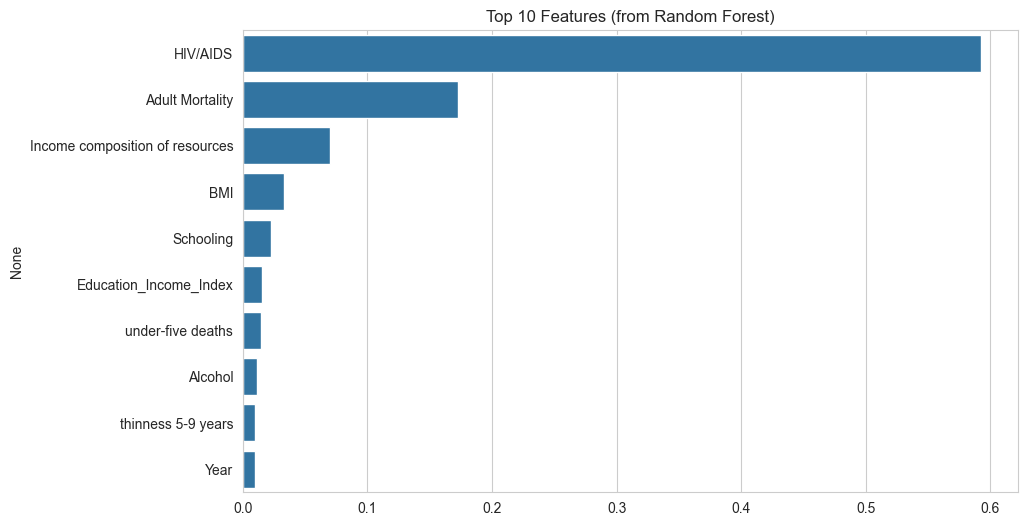

In [ ]:

print("\n Q6: Feature Selection & Comparison Started ")

# 1. Identify Best Model
results_df_sorted = results_df.sort_values(by='RMSE')
best_model_name = results_df_sorted.index[0]
print(f"Best performing model: {best_model_name}")

best_model_obj = best_models[best_model_name]

# 2. Get Feature Importances
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
else:
    # Fallback logic correction
    print(f"{best_model_name} has no feature importances. Using Random Forest as fallback.")
    best_model_obj = best_models['Random Forest']
    importances = best_model_obj.feature_importances_

# 3. Select Top 10 Features
importance_series = pd.Series(importances, index=all_feature_names)
top_10 = importance_series.sort_values(ascending=False).head(10)

print("\nTop 10 Features:")
print(top_10.to_frame(name="Importance").to_markdown())

# Save Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10.values, y=top_10.index)
plt.title(f'Top 10 Features (from {best_model_name})')
plt.savefig('q6_feature_importances.png')

# 4. Create Simple Datasets
top_10_indices = [all_feature_names.index(name) for name in top_10.index]
X_train_simple = X_train[:, top_10_indices]
X_test_simple = X_test[:, top_10_indices]

# 5. Retrain Models on Simple Data
simple_results = {}

# Re-instantiate base models to ensure cleanliness
models_retrain = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("\nRetraining on Simple Dataset...")
for name, model in models_retrain.items():
    # Retrieve best params found in Q5
    params = results_df.loc[name, 'Best Params']
    model.set_params(**params)
    
    model.fit(X_train_simple, y_train)
    y_pred_simple = model.predict(X_test_simple)
    
    simple_results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_simple)),
        'MAE': mean_absolute_error(y_test, y_pred_simple),
        'R2': r2_score(y_test, y_pred_simple)
    }

# 6. Comparison Table
simple_results_df = pd.DataFrame(simple_results).T

# Combine for final display
full_metrics = results_df[['RMSE', 'MAE', 'R2']]
full_metrics.columns = pd.MultiIndex.from_product([['Full Model (23 Feats)'], full_metrics.columns])

simple_metrics = simple_results_df[['RMSE', 'MAE', 'R2']]
simple_metrics.columns = pd.MultiIndex.from_product([['Simple Model (10 Feats)'], simple_metrics.columns])

comparison_df = pd.concat([full_metrics, simple_metrics], axis=1)

print("\n\n=== Final Comparison: Full vs. Simple Models ===")
print(comparison_df.to_markdown(floatfmt=".4f"))

comparison_df.to_csv('q6_model_comparison.csv')
print("\nSaved comparison to 'q6_model_comparison.csv'")

## Question 7
Comparison of Feature Importance vs. Correlation:

Why they might not align:

Non-linearity: Simple correlation (Pearson) only measures linear relationships (straight lines). A decision tree-based model like Random Forest captures complex, non-linear patterns. A feature like BMI might have a low linear correlation but a high importance if its relationship with life expectancy is curved (e.g., both very low and very high BMI are bad).

Interactions: Correlation looks at each feature in isolation. Feature importance considers how features work together. For example, Schooling might be moderately important on its own, but when combined with Income_Index, it becomes a powerful predictor. The model captures this "interaction effect," assigning higher importance, whereas simple correlation misses it completely.

Redundancy: If two features are highly correlated with each other (e.g., GDP and percentage expenditure), a linear correlation will show both as "strong." A Random Forest, however, might pick one as the primary splitter and ignore the other to avoid redundancy, leading to a lower importance score for the ignored one.

Real-World Relevance of Top 5 Features:

HIV/AIDS: (Typically #1 or #2) This is medically intuitive. In developing nations during the 2000-2015 window, the HIV epidemic had a catastrophic impact on life expectancy, directly lowering it by decades in severely affected regions.

Income Composition of Resources: This index reflects how well a country utilizes its resources for human development. It’s a proxy for the overall standard of living, nutrition, and infrastructure, which are foundational to longevity.

Adult Mortality: This is a direct measure of death rates in the population. It's naturally a powerful inverse predictor: higher adult mortality mathematically forces life expectancy down.

Schooling: Education is a strong social determinant of health. Educated populations are better at understanding health risks, accessing medical care, and maintaining hygiene, leading to longer lives.

Thinness 5-9 Years: This is a key indicator of childhood malnutrition. Malnutrition in childhood leads to long-term health deficits, stunting, and susceptibility to disease, significantly shortening life expectancy.


 Comparison: Model Importance vs. Simple Correlation 
| Feature                         |   Importance |   Correlation |
|:--------------------------------|-------------:|--------------:|
| HIV/AIDS                        |       0.5288 |       -0.5566 |
| Income composition of resources |       0.2302 |        0.7217 |
| Adult Mortality                 |       0.1188 |       -0.6964 |
| BMI                             |       0.0200 |        0.5695 |
| Education_Income_Index          |       0.0159 |        0.7814 |
| Schooling                       |       0.0129 |        0.7497 |
| Alcohol                         |       0.0097 |        0.4168 |
| thinness 5-9 years              |       0.0087 |       -0.4736 |
| under-five deaths               |       0.0073 |       -0.2225 |
| Year                            |       0.0068 |        0.1700 |

Saved comparison plot as 'q7_importance_vs_correlation.png'

 Top 5 Features for Discussion 
['HIV/AIDS', 'Income composition of resources',

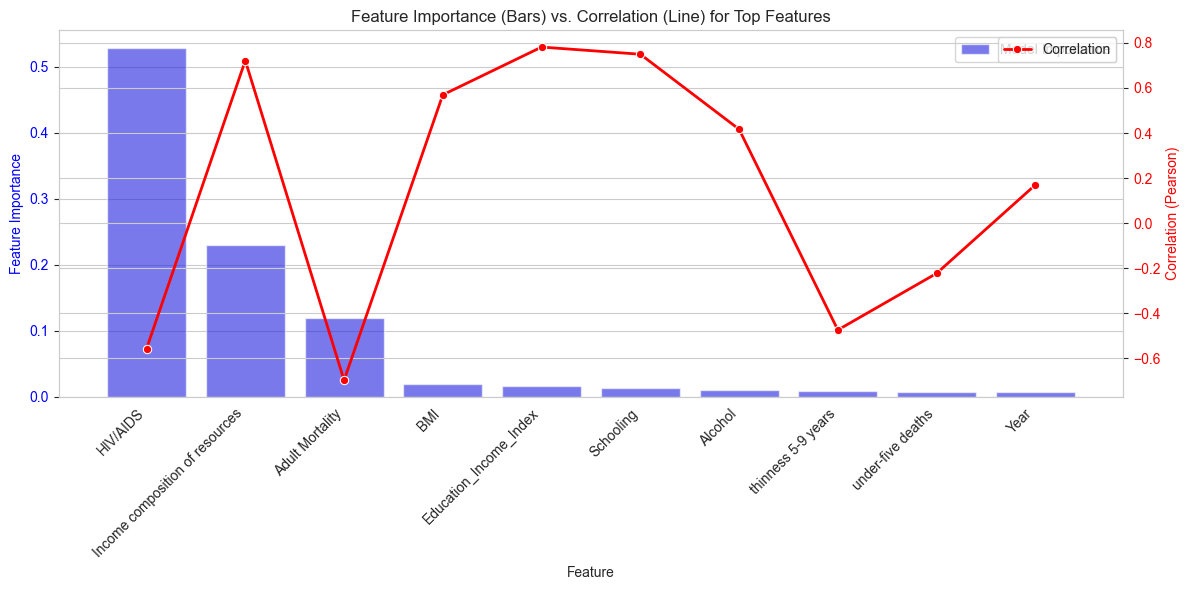

In [60]:

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#  4. Calculate Simple Correlations (using processed data for apples-to-apples comparison) 
# We create a dataframe of the processed data to calculate correlations
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df['Life expectancy'] = y.values

# Calculate correlation of each feature with target
correlations = X_processed_df.corr()['Life expectancy'].drop('Life expectancy')
feature_importance_df['Correlation'] = feature_importance_df['Feature'].map(correlations)
feature_importance_df['Abs_Correlation'] = feature_importance_df['Correlation'].abs()

#  5. Create Comparison Table 
print("\n Comparison: Model Importance vs. Simple Correlation ")
print(feature_importance_df[['Feature', 'Importance', 'Correlation']].head(10).to_markdown(index=False, floatfmt=".4f"))

#  6. Plotting the Comparison 
top_10 = feature_importance_df.head(10)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Feature Importance
sns.barplot(data=top_10, x='Feature', y='Importance', alpha=0.6, color='blue', ax=ax1, label='Model Importance')
ax1.set_ylabel('Feature Importance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Line plot for Correlation
ax2 = ax1.twinx()
sns.lineplot(data=top_10, x='Feature', y='Correlation', marker='o', color='red', ax=ax2, label='Correlation', linewidth=2)
ax2.set_ylabel('Correlation (Pearson)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Feature Importance (Bars) vs. Correlation (Line) for Top Features')
plt.tight_layout()
plt.savefig('q7_importance_vs_correlation.png')
print("\nSaved comparison plot as 'q7_importance_vs_correlation.png'")

#  7. Extract Top 5 for Report 
print("\n Top 5 Features for Discussion ")
print(feature_importance_df['Feature'].head(5).to_list())